# Colab 한글 설치

- 한글 설치하는 코드입니다.

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,813 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

- 런타임 다시 시작한 뒤, 다음 코드를 실행시킵니다.

In [1]:
import matplotlib.font_manager as fm
fm._rebuild()

# 1. 개발 환경 소개

- Google Colab GPU 환경에서 진행했습니다.
- 개발 환경은 다음과 같습니다.

In [2]:
import platform
print('- os:',platform.platform())
print('- 운영체제:', end="")
!cat /etc/issue.net
print('- Process information:', platform.processor())
print('- Process Architecture:', platform.machine())
print("- RAM: 12.68GB")

- os: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
- 운영체제:Ubuntu 18.04.6 LTS
- Process information: x86_64
- Process Architecture: x86_64
- RAM: 12.68GB


In [3]:
print('GPU')
!nvidia-smi

GPU
Thu Aug 11 07:14:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+---

# 2. 라이브러리 불러오기 및 경로 지정

### 라이브러리 불러오기

In [4]:
# 전처리 라이브러리
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from tqdm import tqdm

# 분석 라이브러리
import torch

# 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

# 분석에 문제가 없는 경고 메시지 숨김
import warnings
warnings.filterwarnings('ignore')

### 라이브러리 버전

In [5]:
print('- ', end="")
!python --version
print('- pandas:', pd.__version__)
print('- numpy:', np.__version__)
print('- torch:', torch.__version__)
print('- seaborn:', sns.__version__)

- Python 3.7.13
- pandas: 1.3.5
- numpy: 1.21.6
- torch: 1.12.0+cu113
- seaborn: 0.11.2


### 경로 설정 및 데이터 불러오기

In [6]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


코드 실행을 위해 데이터가 있는 폴더를 설정합니다.

In [7]:
data_dir = '/content/drive/MyDrive/롯데멤버스_경진대회/3. 안다비젼_ 데이터 및 모델 세이브 파일/'

In [18]:
# 데이터 불러오기
demo = pd.read_csv(data_dir+'data/LPOINT_BIG_COMP_01_DEMO.csv') # 고객 데모 정보 - 고객 정보
pdde = pd.read_csv(data_dir+'data/LPOINT_BIG_COMP_02_PDDE.csv', parse_dates=['de_dt']) # 상품 구매 정보 - 유통사 상품 구매 내역
pd_clac = pd.read_csv(data_dir+'data/LPOINT_BIG_COMP_04_PD_CLAC.csv') # 상품 분류 정보 - 유통사 상품 카테고리 마스터

# 3. 재주문 여부 및 기간 계산

* 간단한 전처리 및 재주문 관련 변수를 계산하는 코드입니다.
* 기준 변수는 제품 ID로 잡았습니다.

In [ ]:
data = pdde.copy()


print("\n2. 텍스트 인코딩\n")
user_ids = data["cust"].unique().tolist()
user2user_encoded = {x: int(i) for i, x in enumerate(user_ids)}
order_ids = data["rct_no"].unique().tolist()
order2order_encoded = {x: int(i) for i, x in enumerate(order_ids)}
product_ids = data["pd_c"].unique().tolist()
product2product_encoded = {x: int(i) for i, x in enumerate(product_ids)}

data["cust"] = data["cust"].map(user2user_encoded)
data["rct_no"] = data["rct_no"].map(order2order_encoded)
data["pd_c"] = data["pd_c"].map(product2product_encoded)
data.drop(['cop_c'], axis=1, inplace=True)


print("\n3. 사용자-아이템 행렬 생성\n")
data['temp'] = [0] * len(data)
data_c_pd = pd.DataFrame(data.groupby(['cust', 'pd_c'])['temp'].sum())
data_pivot = data_c_pd.pivot_table('temp', index = 'pd_c', columns = 'cust')
data_pivot.fillna(0, inplace = True)


print("\n4. 재주문 계산\n")
data['de_dt'] = data['de_dt'].astype('str')
data['de_dt'] = pd.to_datetime(data['de_dt'])
data['de_dt'] = (data['de_dt'] - datetime(2021,1,1)).dt.days
data = data.sort_values('de_dt')

custs = torch.Tensor(data["cust"]).cuda() 
rct_nos = torch.Tensor(data["rct_no"]).cuda() 
pd_cs = torch.Tensor(data["pd_c"]).cuda() 
de_dt = torch.Tensor(data["de_dt"]).cuda() 
data_pivot = torch.Tensor(data_pivot.values).cuda() # 각 사용자의 각 아이템별 가장 마지막 주문일자 기록용 테이블

chk_rct = torch.Tensor([0] * 29913).cuda() # 직전 주문기록 기록
reorder = torch.Tensor([0] * len(custs)).cuda() # 재주문 여부 및 횟수, 기간 기록
days_since_prior_order = torch.Tensor([0] * len(custs)).cuda() 

for i in tqdm(range(len(custs))):
  user_now = custs[i].item() # 현재 사용자
  item_now = pd_cs[i].item() # 사용자의 구매 아이템

  if data_pivot[int(item_now)][int(user_now)] == 0: # 구매하지 않았다면
    chk_rct[int(user_now)] = rct_nos[i] # 직전 영수증 번호 입력(같은 구매건 내 동일 제품이 있을 경우를 대비해서)
    data_pivot[int(item_now)][int(user_now)] = de_dt[i] # 구매일자 입력
    
  else: # 구매했던 아이템이라면
    if not rct_nos[i] == chk_rct[int(user_now)]: # 직전 영수증 번호와 현재 영수증 번호가 다르다면
      reorder[i] = 1 # 재주문 여부 입력
      chk_rct[int(user_now)] = rct_nos[i]  # 직전 영수증 번호 업데이트
      days_since_prior_order[i] = de_dt[i] - data_pivot[int(item_now)][int(user_now)] # 재주문 기간 입력
      data_pivot[int(item_now)][int(user_now)] = de_dt[i] # 구매일자 업데이트

print("\n5. 데이터프레임 변환\n")
data_pivot_after = pd.DataFrame(data_pivot.cpu().numpy())
data_after = data.copy()
data_after['reordered'] = reorder.cpu().numpy()
data_after['days_since_prior_order'] = days_since_prior_order.cpu().numpy()


print("\n6. 디코딩\n")
user_ids = pdde["cust"].unique().tolist()
user2user_decoded = {int(i): x for i, x in enumerate(user_ids)}
order_ids = pdde["rct_no"].unique().tolist()
order2order_decoded = {int(i): x for i, x in enumerate(order_ids)}
product_ids = pdde["pd_c"].unique().tolist()
product2product_decoded = {int(i): x for i, x in enumerate(product_ids)}

data_after["cust"] = data_after["cust"].map(user2user_decoded)
data_after["rct_no"] = data_after["rct_no"].map(order2order_decoded)
data_after["pd_c"] = data_after["pd_c"].map(product2product_decoded)


print("\n7. 기타 전처리\n")
data_after = pd.merge(data_after, pd_clac, how='left', on='pd_c')
data_after = pd.merge(data_after, demo, how='left', on='cust')

for i in tqdm(data_after.index): # 요일정보 기록
  data_after['de_dt'][i] = timedelta(days = int(data_after['de_dt'][i])) + datetime(2021,1,1)
data_after['de_dow'] = pd.to_datetime(data_after['de_dt']).dt.strftime("%w")

data_after = data_after[['rct_no', 'cust', 'de_dow', 'de_dt', 'de_hr', 'days_since_prior_order', 'pd_c', 'reordered', 'pd_nm',  'clac_mcls_nm', 'clac_hlv_nm', 'chnl_dv', 'buy_am', 'ma_fem_dv', 'ages', 'zon_hlv']] # 순서, 변수명 지정
data_after.columns = ['order_id', 'user_id', 'order_dow',  'order_date', 'order_hour_of_day', 'day_since_prior_order', 'product_id', 'reordered', 'product_name', 'aisle', 'department', 'chnl_dv', 'buy_am', 'ma_fem_dv', 'ages', 'zon_hlv']
data_after.head(3)


2. 텍스트 인코딩


3. 사용자-아이템 행렬 생성


4. 재주문 계산



100%|██████████| 4381743/4381743 [08:13<00:00, 8870.34it/s] 



5. 데이터프레임 변환


6. 디코딩


7. 기타 전처리



100%|██████████| 4381743/4381743 [02:00<00:00, 36382.61it/s]


,order_id,user_id,order_dow,order_date,order_hour_of_day,day_since_prior_order,product_id,reordered,product_name,aisle,department,chnl_dv,buy_am,ma_fem_dv,ages,zon_hlv
0,A01000001113,M430112881,5,2021-01-01 00:00:00,10,0.0,PD0290,0.0,남성티셔츠,남성의류상의,남성의류,1,15000.0,여성,50대,Z17
1,A02177131465,M632548189,5,2021-01-01 00:00:00,19,0.0,PD1304,0.0,쌈장,장류,조미료,1,980.0,남성,40대,Z10
2,A02177130707,M688055546,5,2021-01-01 00:00:00,18,0.0,PD0480,0.0,기타파티/팬시용품,파티/팬시용품,문구/사무용품,1,5000.0,여성,40대,Z10


* 재주문 변수가 기록된 데이터를 저장합니다.

In [ ]:
data_after.to_csv(data_dir+'output/data_reord.csv', index=False)

# 2. 재주문 변수 EDA

## 2-1. 재주문 거래 형태

* 재주문 거래 형태(비율, 시간, 기간)에 따른 분포를 확인하였습니다. 

In [ ]:
# 파일에서 직접 불러올 경우
data_reord = pd.read_csv(data_dir+'/output/data_reord.csv')
# 위에서 직접 가져올 경우
data_reord = data_after.copy()

In [9]:
rord_tmp = data_reord[data_reord['chnl_dv']==2]

# 1. 전처리
rord_amt = pd.DataFrame(rord_tmp.groupby('day_since_prior_order')['buy_am'].mean()).reset_index()
new_rord_amt = pd.DataFrame({'day_since_prior_order':['0~1','5~14'], 'buy_am':[sum(rord_amt.loc[:1]['buy_am'])/2, sum(rord_amt.loc[5:14]['buy_am'])/10]})
rord_time = pd.DataFrame(rord_tmp.groupby('order_hour_of_day')['reordered'].sum()).reset_index().sort_values('reordered', ascending=False)
rord_rate = rord_tmp['reordered'].value_counts()

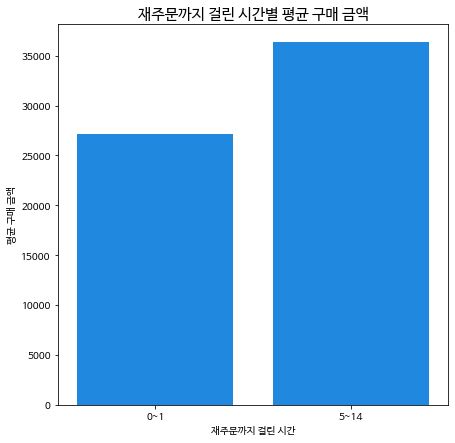

In [10]:
# 2. 시각화
plt.figure(figsize=(7, 7))
sns.barplot(data=new_rord_amt, y= 'buy_am', x ='day_since_prior_order', color='#008BFF')
plt.xlabel('재주문까지 걸린 시간')
plt.ylabel('평균 구매 금액')
plt.title('재주문까지 걸린 시간별 평균 구매 금액', fontsize=15)
plt.show()

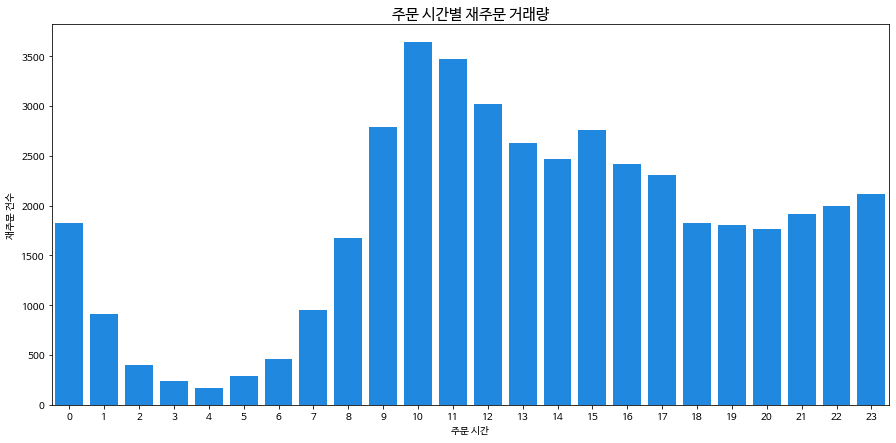

In [11]:
plt.figure(figsize=(15, 7))
sns.barplot(data=rord_time, y= 'reordered', x ='order_hour_of_day', color='#008BFF')
plt.xlabel('주문 시간')
plt.ylabel('재주문 건수')
plt.title('주문 시간별 재주문 거래량', fontsize=15)
plt.show()

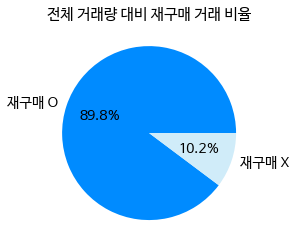

In [12]:
colors = ['#008BFF', '#D0ECF9']
plt.pie([rord_rate[0], rord_rate[1]], labels = ['재구매 O', '재구매 X'], colors = colors, autopct='%.1f%%', textprops={'fontsize': 14})
plt.title("전체 거래량 대비 재구매 거래 비율", fontsize=15)
plt.show()

## 2-2. 소분류별 재주문까지 걸린 기간

* 제품 소분류별 재주문까지 걸리는 평균 시간을 계산하였습니다.

In [19]:
# 1. 재주문 + 상품 데이터 결합
data_reord['day_since_prior_order'] = data_reord['day_since_prior_order'].astype('int')
data_priord = data_reord[(data_reord['reordered']==1)&(data_reord['chnl_dv']==2)][['product_name', 'day_since_prior_order']] # 재구매된 제품들에 대해서 재구매까지 걸린 기간을 뽑아옴
data_priord = pd.DataFrame(data_priord.groupby('product_name')['day_since_prior_order'].mean()).reset_index()
data_priord.columns = ['product_name', 'day_since_prior_order']
data_priord = pd.merge(data_priord, pd_clac, how='left', left_on='product_name', right_on='pd_nm')

# 2. 소분류별 재주문 기간 계산
data_priord_min = pd.DataFrame(data_priord.groupby('pd_nm')['day_since_prior_order'].mean()).reset_index()
data_priord_min = data_priord_min.sort_values('day_since_prior_order', ascending=False).reset_index()

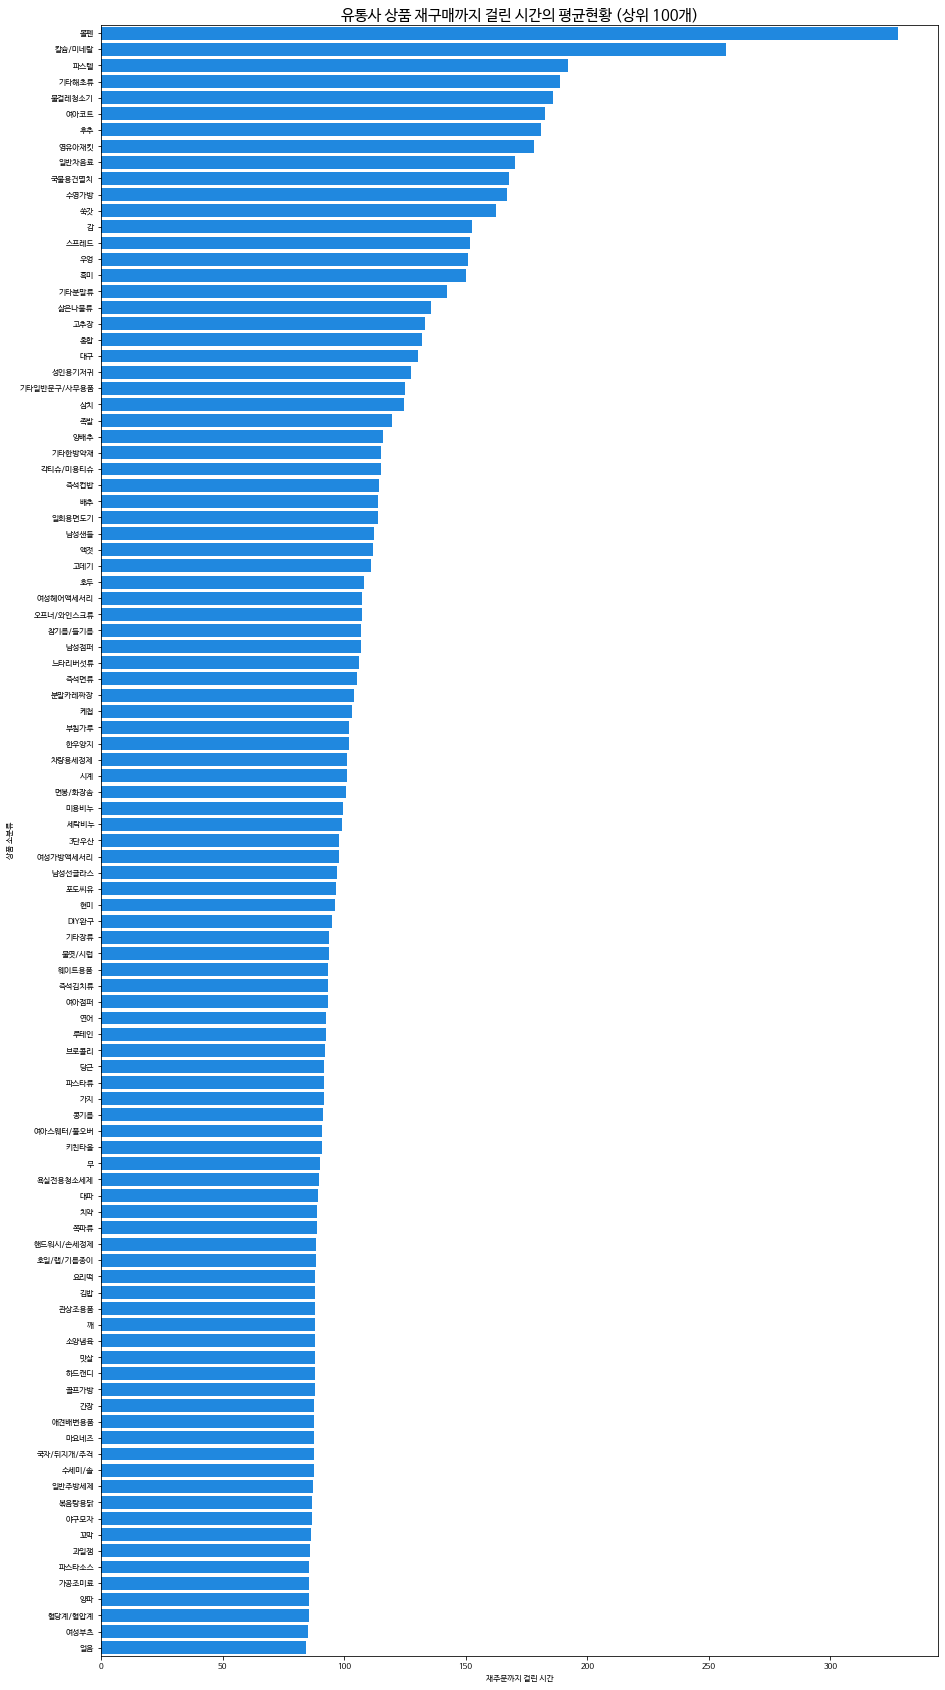

In [20]:
# 3. 시각화
plt.rcParams['font.size'] = 8
plt.figure(figsize=(15, 30), facecolor="white")
sns.barplot(data=data_priord_min.loc[:100], y= 'pd_nm', x ='day_since_prior_order', color='#008BFF')
plt.xlabel('재주문까지 걸린 시간')
plt.ylabel('상품 소분류')
plt.title('유통사 상품 재구매까지 걸린 시간의 평균현황 (상위 100개)', fontsize=15)
plt.show()

## 2-3. 인구 특성별 재구매 고객 비율

* 인구 특성(성별, 연령대, 거주지역)별 재구매 고객의 비율을 확인하였습니다.

0.8569677155700858


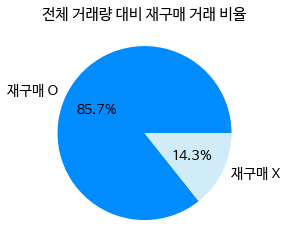

100%|██████████| 26917/26917 [00:06<00:00, 4014.18it/s]


In [21]:
# 1. 데이터 준비
data_reorder_tmp = data_reord[data_reord['chnl_dv']==2] # 온라인 데이터
data_reorder_tmp = pd.DataFrame(data_reord.groupby(['user_id'])['reordered'].sum()).reset_index()
reorder_yn = [False if i==0 else True for i in data_reorder_tmp['reordered']]
print(sum(reorder_yn)/len(reorder_yn))
plt.pie([sum(reorder_yn), len(reorder_yn)-sum(reorder_yn)], labels = ['재구매 O', '재구매 X'], colors = colors, autopct='%.1f%%', textprops={'fontsize': 14})
plt.title("전체 거래량 대비 재구매 거래 비율", fontsize=15)
plt.show()

data_reorder_tmp.columns = ['cust', 'reorder']
for i in tqdm(data_reorder_tmp.index):
  if data_reorder_tmp['reorder'][i]!=0: data_reorder_tmp['reorder'][i] = 1

demo_reorder = pd.merge(demo, data_reorder_tmp, how='outer', on='cust')
demo_reorder = demo_reorder.fillna(0)
demo_reorder['total'] = [1]*len(demo_reorder)

# 2. 계산
demo_reorder_gen = pd.DataFrame(demo_reorder.groupby(['ma_fem_dv'])[['reorder', 'total']].sum()).reset_index()
demo_reorder_reg = pd.DataFrame(demo_reorder.groupby(['zon_hlv'])[['reorder', 'total']].sum()).reset_index()
demo_reorder_age = pd.DataFrame(demo_reorder.groupby(['ages'])[['reorder', 'total']].sum()).reset_index()

demo_reorder_gen['rate'] = demo_reorder_gen['reorder'] / demo_reorder_gen['total']
demo_reorder_reg['rate'] = demo_reorder_reg['reorder'] / demo_reorder_reg['total']
demo_reorder_age['rate'] = demo_reorder_age['reorder'] / demo_reorder_age['total']

<BarContainer object of 2 artists>

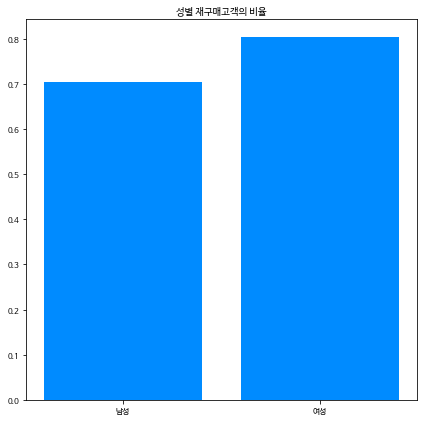

In [22]:
plt.figure(figsize=(7, 7))
plt.title("성별 재구매고객의 비율")
plt.bar(demo_reorder_gen['ma_fem_dv'], demo_reorder_gen['rate'], color='#008BFF')

<BarContainer object of 17 artists>

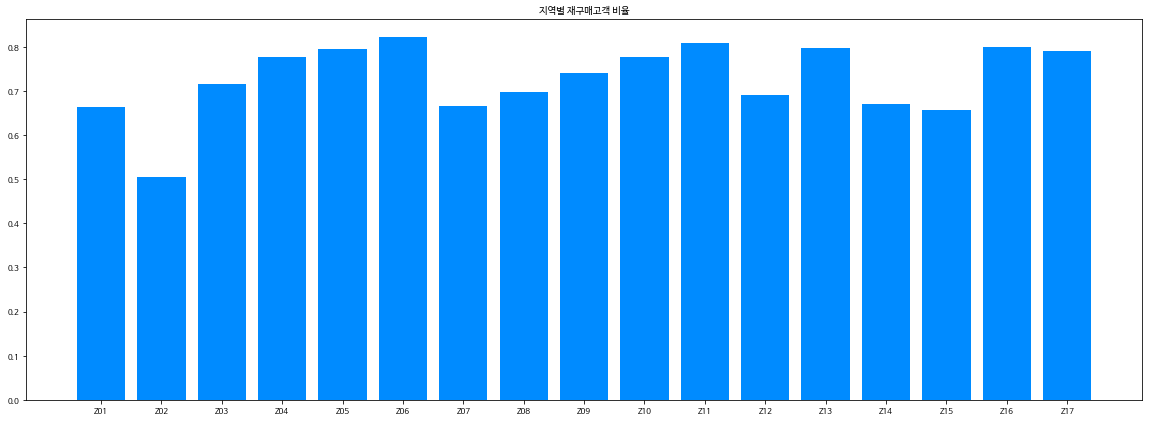

In [23]:
plt.figure(figsize=(20, 7))
plt.title("지역별 재구매고객 비율")
plt.bar(demo_reorder_reg['zon_hlv'], demo_reorder_reg['rate'], color='#008BFF')

<BarContainer object of 6 artists>

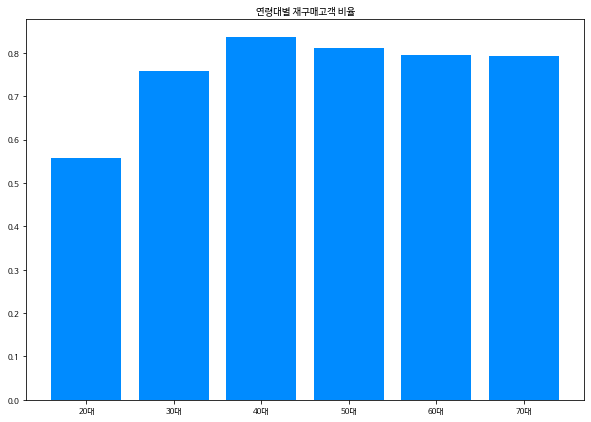

In [24]:
plt.figure(figsize=(10, 7))
plt.title("연령대별 재구매고객 비율")
plt.bar(demo_reorder_age['ages'], demo_reorder_age['rate'], color='#008BFF')